In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import copy
import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import psutil
import random
import rasterio
import segmentation_models as sm
import tensorflow as tf
import time


from pathlib import Path
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.io import MemoryFile
from shapely import geometry
from shapely.geometry.multipolygon import MultiPolygon
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow import keras

2024-12-17 02:30:19.386629: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 02:30:19.524482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734413419.577118  235156 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734413419.592387  235156 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 02:30:19.719391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Segmentation Models: using `tf.keras` framework.


In [2]:
SRC = '/home/jorge/Enviroment/Quantization/'
equalizer_path = f'{SRC}raw/equalizer_Values.pkl'
normalizer_path = f'{SRC}raw/normalizer_Values.pkl'
dataset_path = '/home/jorge/ISI/CEMIG/Testes/02_Macrophytes/ME6_dataset/cenario_1_normalizado/datasets_old/S2_NDVI/'
weights_path = '/home/jorge/Enviroment/01_-_DL_MODELS/CEMIG/macropythes/ME6_model/ME6_cenario_2_normalizado_resnet50_512_v1.h5'
dstest_path = f'{SRC}raw/ds_test/'
patch_size = 128

In [3]:
'''
Utils
'''
def equalizer_compute(item_1, item_2, item_3):
    e_Arr, b_CFD, b_Name = copy.deepcopy(item_1), copy.deepcopy(item_2), copy.deepcopy(item_3)

    H, W, C = e_Arr.shape
    Buffer = np.zeros(shape = (H, W, C), dtype = 'float32')
    for i, b in enumerate(b_Name):
        bl, wh = b_CFD[b]
        np_lst = e_Arr[:, :, i].flatten()
        np_lst = [0 if item < bl else item for item in np_lst ]
        np_lst = [wh if item > wh else item for item in np_lst ]
        np_lst = np.array(np_lst/wh)
        Buffer[:, :, i] = np_lst.reshape(H, W)
    return Buffer


def NDVI_compute (item_1, item_2):
    nir_Band, red_Band = copy.deepcopy(item_1), copy.deepcopy(item_2)

    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')

    # Calculate NDVI
    ndvi = (nir_Band.astype(float) - red_Band.astype(float)) / (nir_Band.astype(float) + red_Band.astype(float))
    ndvi = (ndvi+1)/2       # float pos (0-2)
    ndvi[np.isnan(ndvi)] = 0 
    return ndvi


def normalizer(item_1, item_2, item_3):
    '''
    item_1 = [H, W, C]
    '''
    n_Arr, b_Max, b_Name = copy.deepcopy(item_1), copy.deepcopy(item_2), copy.deepcopy(item_3)
    
    H, W, C = n_Arr.shape
    Buffer = np.zeros(shape = (H, W, C), dtype = 'float32')
    for i, b in enumerate(b_Name):
        v_max = b_Max[b]    #maximo global
        # v_max = np.max(n_Arr[:, :, i])    #Maximo local
        Buffer[:, :, i] = n_Arr[:, :, i]/v_max
    return Buffer


def normalized_difference(item_1, item_2, item_3):
    Raster, b_Name, ndvi_Path, = copy.deepcopy(item_1), copy.deepcopy(item_2), copy.deepcopy(item_3)
    try:
        if type(Raster) is str:     # read each of the rasters
            with rasterio.open(f'{Raster}/B04.jp2') as red_Load:
                H, W = red_Load.height, red_Load.width
                red_Band = red_Load.read()

                # Set spatial characteristics of the output object to mirror the input
                out_meta = red_Load.meta.copy()
                out_meta.update({"count": 1})
                red_Load.close

            with rasterio.open(f'{Raster}/B08.jp2') as nir_Load:
                nir_Band = nir_Load.read()
            nir_Load.close
            ndvi = NDVI_compute(nir_Band, red_Band)
            ndvi = np.reshape(ndvi, (H, W, 1))
            ndvi = ndvi*32767   # UFloat to Uint16

            # save the clipped raster to disk
            with rasterio.open(ndvi_Path, "w", **out_meta) as dest:
                dest.write(ndvi, 1)

        elif type(Raster) is np.ndarray:
            H, W, C = Raster.shape
            id = [i for i, b in enumerate(b_Name) if b == 'B4' or b == 'B8' ]
            red_Band, nir_Band = Raster[:, :, id[0]], Raster[:, :, id[1]]
            ndvi = NDVI_compute(nir_Band, red_Band)
            ndvi = np.reshape(ndvi, (H, W, 1))
            return ndvi
    except ValueError:
        print('Invalid dtype for the function normalized_difference')


def r_crop(item_1, item_2, item_3):
    raster, geo, Size = item_1, copy.deepcopy(item_2), item_3

    if geo.geom_type == 'Polygon':
        geo = MultiPolygon([geo])
       
    
    try:
        patch, outTransform = mask(raster, geo.geoms, all_touched=True, crop=True)
        patch = np.swapaxes(patch, 0, -1)
        patch = np.swapaxes(patch, 0, 1)                    # [H, W, C] - DLmodel format.

        H, W, C = patch.shape
        rdm_arr = np.zeros(shape = (Size, Size, C), dtype = patch.dtype)

        if H > Size or W > Size:
            for i in range(C):
                buffer = patch[:, :, i]
                buffer = r_redim(buffer, Size)
                buffer = r_complete(buffer, Size)
                rdm_arr[:, :, i] = r_redim(buffer, Size)
            return rdm_arr, outTransform                    # [Size, Size, C] - Expected structure by the DLmodel array.
        elif H < Size or W < Size:
            patch = r_complete(patch, Size)
            return patch, outTransform                      # [Size, Size, C] - Expected structure by the DLmodel array.
        return patch, outTransform                          # [Size, Size, C] - Expected structure by the DLmodel array.
    
    except ValueError:
        pass


def r_complete (item_1, item_2):
    patch, Size = item_1, item_2

    try:
        H, W, C  = patch.shape
        x_offset = Size - patch.shape[0]
        arr_com  = np.zeros(shape = (Size, Size, C), dtype = patch.dtype)

        for i in range(C):
            arr_com[:, :, i][ x_offset : x_offset + patch.shape[0],  :  patch.shape[1] ] = patch[:, :, i]
    except ValueError:
        H, W = patch.shape
        x_offset = Size - patch.shape[0]
        arr_com  = np.zeros(shape = (Size, Size), dtype = patch.dtype)

        arr_com[:, :][ x_offset : x_offset + patch.shape[0],  :  patch.shape[1] ] = patch[:, :]
    return arr_com              # [H, W, C] - Expected structure by the DLmodel array.


def r_redim(item_1, item_2):
    patch, Size = item_1, item_2

    while patch.shape[0] > Size:
        for i in range(patch.shape[0]):
            if len(np.unique(patch[i])) == 1:        # The whole row with only a single pixel value.
                patch = np.delete(patch, i, 0)
                break

        if patch.shape[0] > Size:
            patch = np.delete(patch, 0, 0)

    while patch.shape[1] > Size:                    # The whole col with only a single pixel value.
        for i in range(patch.shape[1]):
            if len(np.unique(patch[:, i])) == 1:
                patch = np.delete(patch, i, 1)
                break
        if patch.shape[1] > Size:
            patch = np.delete(patch, Size-1, 1)
    return patch


def check_geoms(item1):
    try:
        geom = item1.geometry

        if geom.geom_type[0] == 'Polygon':
            geom = MultiPolygon([geom[0]])
    except:
        pass
    return geom


def validation_dir(item_1):
    folder_Dir = Path(item_1)
    try:
        if not os.path.exists(folder_Dir):
            folder_Dir.mkdir(parents=True, exist_ok=True)
    except:
        pass  


In [4]:
def memfile_crt(data, outMeta):
    with MemoryFile() as memfile:
        with memfile.open(**outMeta) as dataset:
            dataset.write(data)    

        # rasterio.io.DatasetWrite -->  rasterio.io.DatasetReader               
        return memfile.open()  

In [5]:
def fishnet_compute(item1, item2):
    raster, size = item1, item2
    
    pixel_resolution = raster.transform[0]
    total_bounds = list(raster.bounds)
    crs = raster.crs

    # Get minX, minY, maxX, maxY
    minX, minY, maxX, maxY = total_bounds
 
    # Create a fishnet
    x, y = (minX, minY)
    geom_array = []
 
    # Polygon Size
    square_size = size * pixel_resolution
    while y <= maxY:
        while x <= maxX:
            geom = geometry.Polygon([(x, y), 
                                     (x, y + square_size), 
                                     (x + square_size, y + square_size), 
                                     (x + square_size, y), (x, y)])
            geom_array.append(geom)
            x += square_size
        x = minX
        y += square_size
 
    fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs(crs)

    return fishnet, crs

In [6]:
def geo_compute(item1, item2, item3, item4):
    patche_arr, outTransform, size, crs = copy.deepcopy(item1), copy.deepcopy(item2), copy.deepcopy(item3), copy.deepcopy(item4)

    outTransform = rasterio.Affine(outTransform[0], 0, outTransform[2], 0, outTransform[4], outTransform[5])

    #raster.profile
    outMeta = { 'driver':'GTiff', 
                'dtype':'uint8', 
                'nodata':0, 
                'width':size,         
                'height':size,         
                'count':1, 
                'crs':crs,
                'transform':outTransform, 
                'tiled':False, 
                'interleave':'band'
              }
    
    patche_arr.resize(1, size, size)   
    return patche_arr, outMeta

In [7]:
"""
Inference arr
"""
def arr_compute(item1, item2, item3, item4):
    raster, geo, max_Valu, size = item1, item2, item3, item4
    bands_nm = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
    flag = bool(None)
    
    try:
        flag = bool(True)
        # create data s2.
        S2_Patch, outTransform = r_crop(raster, geo, size)      # pacth S2 [X, X, 10], Uint16
        S2_Patch[np.isnan(S2_Patch)] = 0                        # Uint16
        S2_Norm = normalizer(S2_Patch, max_Valu, bands_nm)      # 0-1 flaot32 


        # create ndvi.
        ndvi_Arr = normalized_difference(S2_Patch, bands_nm,'')


        # create data s2+ normalizer.     
        H, W, C = S2_Norm.shape
        S2_NDVI = np.zeros(shape = (H, W, C+1), dtype = np.float32)
        for i in range(C):
            S2_NDVI[:, :, i] = S2_Norm[:, :, i]
        S2_NDVI[:, :, C] = ndvi_Arr[:, :, 0]
    
    except ValueError:
        S2_NDVI, outTransform, flag = [], [], bool(False)
        
    
    return S2_NDVI, outTransform, flag

In [8]:
def mosaic_compute(raster_to_mosiac, output_meta):

    mosaic, output = merge(raster_to_mosiac)     
    output_meta.update({ "driver": "GTiff",
                         "height": mosaic.shape[1],
                         "width": mosaic.shape[2],
                         "transform": output })        
    return mosaic, output_meta

In [9]:
def compose_ds(item1):

    x_ds = sorted([ f.path for f in os.scandir(item1) if f.is_file() ])

    for i, arr_dir in enumerate(x_ds):
        arr = np.load(arr_dir).astype(np.float32)
        H, W, C = arr.shape

        arr = cv2.resize(arr, (H*4, W*4),interpolation = cv2.INTER_LINEAR)
        arr = np.reshape(arr, (1, H*4, W*4, C)) 
 

        if i == 0:
            ds_compose = arr
        else:
            ds_compose = np.concatenate((ds_compose, arr), axis=0)
            
    return ds_compose

In [10]:
"""
Load models
"""


model = sm.Unet('resnet50', 
                classes = 1,  
                encoder_weights = None,
                input_shape = (512, 512, 11), 
                activation = 'sigmoid' )
    
model.load_weights(weights_path)    
model.save('model.h5')     

2024-12-17 02:30:46.749258: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-17 02:30:46.749278: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: CTX3F14
2024-12-17 02:30:46.749282: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: CTX3F14
2024-12-17 02:30:46.749358: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 560.35.3
2024-12-17 02:30:46.749367: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 560.35.3
2024-12-17 02:30:46.749369: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 560.35.3


In [11]:
validation_dir(f'{SRC}code/result/gt/')
validation_dir(f'{SRC}code/result/pr/')
validation_dir(f'{SRC}code/result/inference/')


# load equalized files.
with open(equalizer_path, 'rb') as equ_File:
    equalizerfile = pickle.load(equ_File)       


# load equalized files.
with open(normalizer_path, 'rb') as norm_File:
    normalizerfile = pickle.load(norm_File)    


raster_dir = f'{dstest_path}raster/'
labels_dir = f'{dstest_path}mask/'
for name in os.listdir(raster_dir):

    # compute the raster scene.
    with rasterio.open(f'{raster_dir}{name}') as raster:   
        scene_mosaic = memfile_crt(raster.read(), raster.profile)


    # Patchs geometries.
    geometries, crs = fishnet_compute(scene_mosaic, patch_size)  # CRS = temp_r  


    # compute the raster scene.
    raster_to_mosiac = []
    for geo in geometries['geometry']:

        arr, outTransform, flag = arr_compute(scene_mosaic, geo, normalizerfile, patch_size)

        if flag:
            arr = cv2.resize(arr, (patch_size*4, patch_size*4),interpolation = cv2.INTER_LINEAR)
            H, W, C = arr.shape
            arr = np.reshape(arr, (1, H, W, C))

            pr_mask = (model.predict(arr) > 0.5).astype(np.uint8)
            pr_mask = np.reshape(pr_mask, (H, W, 1))
            pr_mask = cv2.resize(pr_mask, (patch_size, patch_size), interpolation = cv2.INTER_NEAREST)

            mosaic, outMeta = geo_compute(pr_mask, outTransform, patch_size, crs)

            raster_memf = memfile_crt(mosaic, outMeta)
            raster_to_mosiac.append(raster_memf)    #raster_list.


        if bool(raster_to_mosiac):  #se não estiver vazio.
            output_meta = raster_memf.meta.copy()
            mosaic, outMeta = mosaic_compute(raster_to_mosiac, output_meta)
            predict_memf = memfile_crt(mosaic, outMeta)


    with rasterio.open(f'{SRC}code/result/inference/{name}.tif', 'w', **predict_memf.profile) as m:
        m.write(predict_memf.read())

    np.save(f'{SRC}code/result/pr/{name}', predict_memf.read(1))       

    with rasterio.open(f'{labels_dir}{name}') as label:   
        np.save(f'{SRC}code/result/gt/{name}', label.read(1))      

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [12]:

for i, name in enumerate(os.listdir(f'{SRC}code/result/gt/')):
    gt_arr = np.load(f'{SRC}code/result/gt/{name}')
    pr_arr = np.load(f'{SRC}code/result/pr/{name}')
    pr_arr = pr_arr[:, 0:178]

    if i == 0:
        y_true = gt_arr
        y_pred = pr_arr
    else:
        y_true = np.concatenate((y_true, gt_arr), axis=None)
        y_pred = np.concatenate((y_pred, pr_arr), axis=None)


def iou_coe(y_true, y_pred):
    intersect = np.sum(y_pred*y_true)
    union = np.sum(y_pred) + np.sum(y_true) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)


tamanho_modelo = os.path.getsize('model.h5') / (1024 * 1024)  # tamanho em MB
print('f1_score modelo não quantizado:', f1_score(y_true, y_pred))
print('IoU modelo não quantizado:', iou_coe(y_true, y_pred))
print('precision modelo não quantizado:', precision_score(y_true, y_pred))
print('recall_score modelo não quantizado:', recall_score(y_true, y_pred))
print('Tamanho do modelo: {:.2f} MB'.format(tamanho_modelo))

f1_score modelo não quantizado: 0.7773235213954756
IoU modelo não quantizado: 0.636
precision modelo não quantizado: 0.6419567827130852
recall_score modelo não quantizado: 0.9850333870596362
Tamanho do modelo: 124.96 MB


In [13]:
## Compor conjunto de dados
x_train = compose_ds(f'{dataset_path}train/')
# x_test = compose_ds(f'{dataset_path}test/')
# y_test = compose_ds(f'{dataset_path}test_mask/')
# x_eval = compose_ds(f'{dataset_path}validation/')

In [89]:
x_test = compose_ds(f'{dataset_path}test/')

In [91]:
##tempo médio de inferência do modelo original
def avaliar_modelo_keras_tempo(modelo):
    total_time = 0
    total_mem = 0
    for i in range(len(x_test)):
        input_data = x_test[i:i+1]

        #uso de memória antes da inferência
        process = psutil.Process(os.getpid())
        mem_before = process.memory_info().rss / (1024 * 1024)

        start_time = time.time()
        _ = modelo.predict(input_data, verbose=0)
        inference_time = time.time() - start_time
        total_time += inference_time

        #uso de memória após a inferência
        mem_after = process.memory_info().rss / (1024 * 1024)
        mem_usage = mem_after - mem_before
        total_mem += mem_usage

    tempo_medio_inferencia = total_time / len(x_test)
    mem_medio_inferencia = total_mem / len(x_test)
    print('Tempo médio de inferência (modelo original): {:.6f} segundos'.format(tempo_medio_inferencia))
    print('Uso médio de memória durante a inferência: {:.4f} MB'.format(mem_medio_inferencia))
    return tempo_medio_inferencia, mem_medio_inferencia

tempo_keras, mem_keras = avaliar_modelo_keras_tempo(model)

Tempo médio de inferência (modelo original): 0.281249 segundos
Uso médio de memória durante a inferência: 0.0087 MB


In [64]:
# Quantização Pós-Treinamento usando TensorFlow Lite
# Otimizações padrão
# OPTIMIZE_FOR_SIZE Deprecated. Does the same as DEFAULT.
# OPTIMIZE_FOR_LATENCY Deprecated. Does the same as DEFAULT.

converter = tf.lite.TFLiteConverter.from_keras_model(model) #keras para modelo compativel com TFL (onde Quantização será aplicada)
converter.optimizations = [tf.lite.Optimize.DEFAULT] #ativa otimizaçoes que incluem as técnicas de quantização


# Para quantização completa (inteiro), precisamos de um dataset representativo. calibração de pesos e ativações
def representative_dataset():
    for i in range(1):
        yield [x_train[i:i+1]]

converter.representative_dataset = representative_dataset #indica o dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] #utiliza apenas operaçoes TFL que suportam INT8



# Converter o modelo
modelo_quantizado = converter.convert() #converte o modelo


# Salvar o modelo quantizado
with open('qmodel.tflite', 'wb') as f:
    f.write(modelo_quantizado)

# Tamanho do modelo quantizado
tamanho_modelo_quantizado = os.path.getsize('qmodel.tflite') / (1024 * 1024)
print('Tamanho do modelo quantizado: {:.2f} MB'.format(tamanho_modelo_quantizado))

INFO:tensorflow:Assets written to: /tmp/tmpcbc66dai/assets


INFO:tensorflow:Assets written to: /tmp/tmpcbc66dai/assets


Saved artifact at '/tmp/tmpcbc66dai'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 512, 512, 11), dtype=tf.float32, name='data')
Output Type:
  TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None)
Captures:
  129735363682640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129735363683408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129735363681872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129735363683024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129735363685904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129735363683216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129735363682832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129735363680336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129735363686672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129735363684560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12973536368

/home/jorge/Enviroment/Quantization/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1734417781.588886  235156 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734417781.588905  235156 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-17 03:43:01.589044: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpcbc66dai
2024-12-17 03:43:01.597479: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-17 03:43:01.597507: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpcbc66dai
2024-12-17 03:43:01.694985: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-17 03:43:02.272037: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at pa

Tamanho do modelo quantizado: 31.76 MB


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


In [71]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="qmodel.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [74]:
np_res_im = np.load('/home/jorge/ISI/CEMIG/Testes/02_Macrophytes/ME6_dataset/cenario_1_normalizado/datasets/S2_NDVI/test/1057.npy')
input_details[0]['shape']

array([  1, 512, 512,  11], dtype=int32)

In [75]:
np_res_im = cv2.resize(np_res_im, (patch_size*4, patch_size*4),interpolation = cv2.INTER_LINEAR)
np_res_im.shape

(512, 512, 11)

In [76]:
if len(np_res_im.shape) == 3:
    np_res_im = np.expand_dims(np_res_im, 0)
# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np_res_im
print(input_data.shape)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
output_data.shape

(1, 512, 512, 11)


(1, 512, 512, 1)

(512, 512)


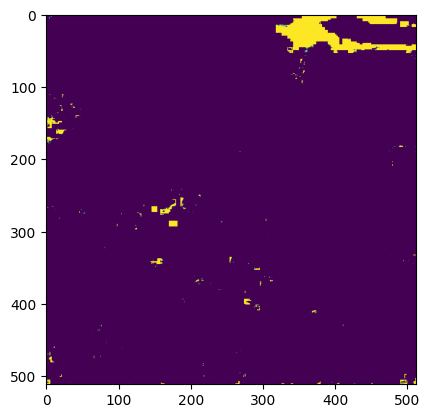

In [70]:
import matplotlib.pyplot as plt

T, H, W, C = output_data.shape
output_data2 = np.reshape(output_data, (H, W))
print(output_data2.shape)



plt.imshow(output_data2)
plt.show()


In [87]:
validation_dir(f'{SRC}code/result/q_gt/')
validation_dir(f'{SRC}code/result/q_pr/')
validation_dir(f'{SRC}code/result/q_inference/')


# load equalized files.
with open(equalizer_path, 'rb') as equ_File:
    equalizerfile = pickle.load(equ_File)       


# load equalized files.
with open(normalizer_path, 'rb') as norm_File:
    normalizerfile = pickle.load(norm_File)    


raster_dir = f'{dstest_path}raster/'
labels_dir = f'{dstest_path}mask/'
for name in os.listdir(raster_dir):

    # compute the raster scene.
    with rasterio.open(f'{raster_dir}{name}') as raster:   
        scene_mosaic = memfile_crt(raster.read(), raster.profile)


    # Patchs geometries.
    geometries, crs = fishnet_compute(scene_mosaic, patch_size)  # CRS = temp_r  


    # compute the raster scene.
    raster_to_mosiac = []
    for geo in geometries['geometry']:

        arr, outTransform, flag = arr_compute(scene_mosaic, geo, normalizerfile, patch_size)

        if flag:
            arr = cv2.resize(arr, (patch_size*4, patch_size*4),interpolation = cv2.INTER_LINEAR)
            H, W, C = arr.shape
            arr = np.reshape(arr, (1, H, W, C))


            interpreter.set_tensor(input_details[0]['index'], arr)
            interpreter.invoke()
            pr_mask = interpreter.get_tensor(output_details[0]['index'])
            pr_mask = (pr_mask> 0.5).astype(np.uint8)
            # pr_mask = (model.predict(arr) > 0.5).astype(np.uint8)
            pr_mask = np.reshape(pr_mask, (H, W, 1))
            pr_mask = cv2.resize(pr_mask, (patch_size, patch_size), interpolation = cv2.INTER_LINEAR)

            mosaic, outMeta = geo_compute(pr_mask, outTransform, patch_size, crs)

            raster_memf = memfile_crt(mosaic, outMeta)
            raster_to_mosiac.append(raster_memf)    #raster_list.


        if bool(raster_to_mosiac):  #se não estiver vazio.
            output_meta = raster_memf.meta.copy()
            mosaic, outMeta = mosaic_compute(raster_to_mosiac, output_meta)
            predict_memf = memfile_crt(mosaic, outMeta)


    np.save(f'{SRC}code/result/q_pr/{name}', predict_memf.read(1))       

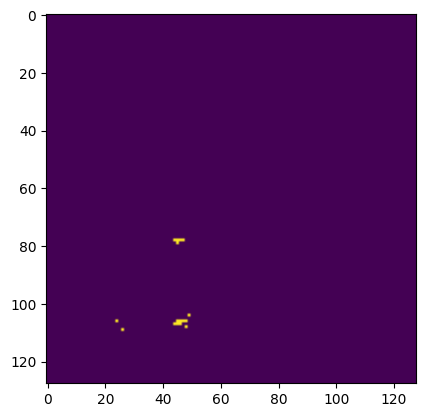

In [88]:
plt.imshow(pr_mask)
plt.show()

In [93]:
for i, name in enumerate(os.listdir(f'{SRC}code/result/gt/')):
    gt_arr = np.load(f'{SRC}code/result/gt/{name}')
    pr_arr = np.load(f'{SRC}code/result/q_pr/{name}')
    pr_arr = pr_arr[:, 0:178]

    if i == 0:
        y_true = gt_arr
        y_pred = pr_arr
    else:
        y_true = np.concatenate((y_true, gt_arr), axis=None)
        y_pred = np.concatenate((y_pred, pr_arr), axis=None)


def iou_coe(y_true, y_pred):
    intersect = np.sum(y_pred*y_true)
    union = np.sum(y_pred) + np.sum(y_true) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)


tamanho_modelo = os.path.getsize('qmodel.tflite') / (1024 * 1024)  # tamanho em MB
print('f1_score modelo não quantizado:', f1_score(y_true, y_pred))
print('IoU modelo não quantizado:', iou_coe(y_true, y_pred))
print('precision modelo não quantizado:', precision_score(y_true, y_pred))
print('recall_score modelo não quantizado:', recall_score(y_true, y_pred))
print('Tamanho do modelo: {:.2f} MB'.format(tamanho_modelo))

f1_score modelo não quantizado: 0.09370548198174432
IoU modelo não quantizado: 0.049
precision modelo não quantizado: 0.06078028747433265
recall_score modelo não quantizado: 0.20446695832373935
Tamanho do modelo: 31.76 MB
